# try env here


In [28]:

import ee

ModuleNotFoundError: No module named 'ee'

In [29]:
import geemap

ModuleNotFoundError: No module named 'geemap'

# need to replace this function 

`suhi.get_landsat_features_ds(landsat_tile, ref_ds=ref_ds, **landsat_features_kws)`

In [30]:
import swiss_uhi_utils as suhi
help(suhi.get_landsat_features_ds)

Help on function get_landsat_features_ds in module swiss_uhi_utils.landsat:

get_landsat_features_ds(landsat_tile, landsat_features=None, ref_ds=None, ref_geom=None, water_bodies_geom=None, crs=None, roi=False, subset_kws=None, roi_kws=None)



In [ ]:
#code part to be replaced invoking the above function

In [9]:
# process the list of tiles
    datasets = []
    # use a head-tail pattern to get a reference dataset in the first
    # iteration and use it to align the datasets of further iterations
    landsat_features_kws = dict(landsat_features=['lst', 'ndwi'],
                                ref_geom=ref_geom,
                                water_bodies_geom=None,
                                crs=crs)
    ref_ds = suhi.get_landsat_features_ds(landsat_tiles[0],
                                          **landsat_features_kws)
    datasets.append(ref_ds)
    for landsat_tile in landsat_tiles[1:]:
        ds = suhi.get_landsat_features_ds(landsat_tile,
                                          ref_ds=ref_ds,
                                          **landsat_features_kws)
        datasets.append(ds)

    agglom_landsat_ds = xr.concat(datasets, dim='time')

IndentationError: unexpected indent (3471381691.py, line 2)

In [ ]:
# the idea is to use geemap and ee to do the same things as in suhi

In [1]:

import tempfile
from os import path

import numpy as np
import pandas as pd
import pylandsat
import salem
import xarray as xr
from rio_toa import brightness_temp


In [8]:
# geo_utils is file of suhi_utils
from . import geo_utils

__all__ = ['get_landsat_features_ds']

ImportError: attempted relative import with no known parent package

In [12]:
def get_landsat_features_ds(landsat_tile, landsat_features=None, ref_ds=None,
                            ref_geom=None, water_bodies_geom=None, crs=None,
                            roi=False, subset_kws=None, roi_kws=None):
    product = pylandsat.Product(landsat_tile)

    with tempfile.TemporaryDirectory() as tmp_dir:
        product.download(tmp_dir, files=LANDSAT_FILES)

        landsat_tile_dir = path.join(tmp_dir, landsat_tile)

        scene = pylandsat.Scene(landsat_tile_dir)
        bands = scene.available_bands()
        band_filepaths = [getattr(scene, band).fpath for band in bands]

        # create xarray dataset
        landsat_ds = xr.Dataset({
            band: salem.open_xr_dataset(band_filepath)['data']
            for band, band_filepath in zip(bands, band_filepaths)
        })
    # projection attributes need to be set before any geo-transformation
    proj_attrs = landsat_ds[bands[0]].attrs.copy()
    landsat_ds.attrs = proj_attrs

    # landsat metadata that will be used below
    mtl_dict = scene.mtl

    # crop/align to the reference extent
    if ref_ds is None:
        landsat_ds = geo_utils.clip_ds_to_extent(landsat_ds, geom=ref_geom,
                                                 crs=crs, roi=roi,
                                                 subset_kws=subset_kws,
                                                 roi_kws=roi_kws)
    else:
        landsat_ds = ref_ds.salem.transform(landsat_ds, interp='linear')

    # the water mask needs to be boolean for NumPy slicing to work properly
    water_bodies_mask = landsat_ds.salem.grid.region_of_interest(
        geometry=water_bodies_geom, crs=crs).astype(bool)

    # compute the landsat features set in `landsat_features`
    if landsat_features is None:
        landsat_features = ['lst', 'ndvi', 'ndwi']
    landsat_features_dict = {}
    if 'lst' in landsat_features:
        landsat_features_dict['lst'] = _compute_lst(landsat_ds, mtl_dict,
                                                    water_bodies_mask)
    if 'ndvi' in landsat_features:
        landsat_features_dict['ndvi'] = _compute_ndvi(landsat_ds)
    if 'ndwi' in landsat_features:
        landsat_features_dict['ndwi'] = _compute_ndwi(landsat_ds,
                                                      water_bodies_mask)

    # assemble the final dataset
    dims = ('y', 'x')
    coords = {
        'x': landsat_ds.salem.grid.x_coord,
        'y': landsat_ds.salem.grid.y_coord
    }
    landsat_features_ds = xr.Dataset(
        {
            landsat_feature_key: xr.DataArray(
                landsat_features_dict[landsat_feature_key], dims=dims,
                coords=coords, attrs=proj_attrs)
            for landsat_feature_key in landsat_features_dict
        }, attrs=proj_attrs)
    # add the date
    landsat_features_ds = landsat_features_ds.assign_coords({
        'time':
        pd.to_datetime(mtl_dict['PRODUCT_METADATA']['DATE_ACQUIRED'])
    })

    return landsat_features_ds

## getting started of geemap and ee

In [ ]:
ee token

4/1AWgavdd9xm1IzwUNuDntgPlqVJyuhtQdE41q0_hxAKFztRyJsG_PlJ9q71c

In [23]:
Map = geemap.Map(center=(40, -100), zoom=4)
#Map
dem = ee.Image('USGS/SRTMGL1_003')
landcover = ee.Image("ESA/GLOBCOVER_L4_200901_200912_V2_3").select('landcover')
landsat7 = ee.Image('LANDSAT/LE7_TOA_5YEAR/1999_2003')
states = ee.FeatureCollection("TIGER/2018/States")
countries = geemap.shp_to_ee('data/raw/agglom-extent/agglom-extent.shp')

dem_vis = {
'min': 0,
'max': 4000,
'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

landsat_vis = {
    'min': 20,
    'max': 200,
    'bands': ['B4', 'B3', 'B2']
}
aggr_vis_params = {'color': 'f70202ff', 'width': 2, 'lineType': 'solid', 'fillColor': '00000056'}

In [147]:
Map.addLayer(dem, dem_vis, 'SRTM DEM', True, 0.5)
Map.addLayer(landcover, {}, 'Land cover')
Map.addLayer(landsat7, landsat_vis, 'Landsat 7')
Map.addLayer(states, {}, "US States")
Map.addLayer(countries, aggr_vis_params, 'Countries')
Map.addLayer(geometry,  {},'geometry');

Map

Map(bottom=46983.0, center=[45.899565963770335, 11.157989501953127], controls=(WidgetControl(options=['positio…

In [19]:
# download tiles ee

## read in landsat tiles


In [54]:
landsat_tiles = pd.read_csv('data/raw/landsat-tiles.csv', header=None)[0]
landsat_tiles

0    LC08_L1TP_192028_20220625_20220706_01_T1
1    LC08_L1TP_193028_20220702_20220708_01_T1
2    LC08_L1TP_192028_20220711_20220722_01_T1
3    LC08_L1TP_193028_20220718_20220726_01_T1
Name: 0, dtype: object

In [55]:
landsat_tile = landsat_tiles[0]
landsat_tile

'LC08_L1TP_192028_20220625_20220706_01_T1'

In [146]:
#define geometry
geometry = ee.Geometry.Polygon(
        [[[10.956465573588993, 46.25],
          [10.956465573588993, 45.90],
          [11.338240475932743, 45.90],
          [11.338240475932743, 46.25]]])

In [50]:
date_start = '2022-06-24'
date_end = '2022-07-19'

In [105]:
#locate the tile #T1_L2 #T1_TOA
l2sp = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA").filterDate(date_start, date_end).filter(ee.Filter.bounds(geometry))

In [106]:
l2sp

In [107]:
l2sp_first = l2sp.first().select('B10').multiply(0.00341802).add(149.0)
l2sp_first

In [108]:
#visualization
cmap1 = ['blue', 'cyan', 'green', 'yellow', 'red']

l2sp_vis = {
'min': 260,
'max': 320,
'palette': cmap1}

In [80]:
# compute lst, ndvi, ndwi
# try import modules
LandsatLST = require('users/rbeber/gee_lst_landsat:modules/Landsat_LST.js')


NameError: name 'require' is not defined

In [109]:
def addNDVI(image):
    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

#// Test the addNDVI function on a single image.
#ndvi = addNDVI(image).select('NDVI');

In [110]:
# apply to all collection
withNDVI = l2sp.map(addNDVI)
#l2sp_first = l2sp.first().select('ST_B10').multiply(0.00341802).add(149.0)


In [111]:
ndvi_vis = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}

In [112]:
withNDVI

In [113]:

Map = geemap.Map(center=(46.076, 11.21), zoom=10)
#add layer to map
Map.addLayer(l2sp_first, l2sp_vis, 'ST_B10', True, 0.9)
Map.addLayer(geometry,  {},'geometry');
Map.addLayer(withNDVI.first().select('NDVI'),  ndvi_vis,'NDVI');

Map

Map(center=[46.076, 11.21], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childr…

# Check out TOA products

In [103]:
point = ee.Geometry.Point([-122.292, 37.9018])

#// Import the Landsat 8 TOA image collection.
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA');

#// Get the least cloudy image in 2015.
image = ee.Image(
  l8.filterBounds(point)
    .filterDate('2015-01-01', '2015-12-31')
    .sort('CLOUD_COVER')
    .first())

In [104]:
#// Compute the Normalized Difference Vegetation Index (NDVI).
nir = image.select('B5');
red = image.select('B4');
ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI');

#// Display the result.
Map.centerObject(image, 9);
ndviParams = {min: -1, max: 1, 'palette': ['blue', 'white', 'green']}
Map.addLayer(ndvi, ndviParams, 'NDVI image')
Map

# FOR TIME BEING IS EASIER TO PROCESS THEM ALL IN EE AND EXPORT THE GeoTIFF

exported 4 tiles with the bands addede LST, NDVI & NDWI!!

downloadede zip for now, let's see if visible

In [9]:
pwd

'/home/beber/fbk_sandbox/swiss_uhi/tn_uhi'

In [10]:
lst_gee_tiles = 'data/raw/landsat_gee_tiles/gee_uhi-20230118T151928Z-001/gee_uhi/'

In [11]:
tile0 = 'uhi_LC08_192028_20220625.tif'

In [12]:
ll {lst_gee_tiles}

total 157886
-rw-rw-r-- 1 beber    12495 gen 19 16:47 id_a.csv
-rw-rw-r-- 1 beber 40117654 gen 18 07:18 uhi_LC08_192028_20220625.tif
-rw-rw-r-- 1 beber     7348 gen 20 15:36 uhi_LC08_192028_20220625.tif.aux.xml
-rw-rw-r-- 1 beber 40794631 gen 18 07:18 uhi_LC08_192028_20220711.tif
-rw-rw-r-- 1 beber 42320418 gen 18 07:18 uhi_LC08_193028_20220702.tif
-rw-rw-r-- 1 beber 38256999 gen 18 07:18 uhi_LC08_193028_20220718.tif


In [134]:
import geemap.colormaps as cm

In [148]:

Map = geemap.Map(center=(46.076, 11.21), zoom=10)
#add layer to map
Map.addLayer(l2sp_first, l2sp_vis, 'ST_B10', True, 0.9)
Map.addLayer(geometry,  {},'geometry');
Map.addLayer(withNDVI.first().select('NDVI'),  ndvi_vis,'NDVI');
Map.add_raster(lst_gee_tiles+tile0,[4,3,2],colormap = 'terrain')
Map

Map(center=[46.076, 11.21], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childr…

!mamba install -c conda-forge xarray_leaflet


In [159]:
# read in local image
locImage = ee.Image.loadGeoTIFF(lst_gee_tiles+tile0)

In [162]:
locImage.bandNames().getInfo()

EEException: Image.loadGeoTIFF: Invalid GCS URL: "data/raw/landsat_gee_tiles/gee_uhi-20230118T151928Z-001/gee_uhi/uhi_LC08_192028_20220625.tif". Expected something of the form "gs://bucket/path/to/object".

# Read LST processed tiles in GEE and convert to SUHI style
## actually, read in multy-band gdal, save , NDVI, NDWI, LST computed in GEE editor and go ahead

1. read tile
2. trim tile
3. get landsat feature
4. 

In [2]:
lst_gee_tiles = 'data/raw/landsat_gee_tiles/gee_uhi-20230118T151928Z-001/'
#gee_uhi/

In [3]:
tile0 = 'uhi_LC08_192028_20220625.tif'

In [4]:
from osgeo import gdal
tile = gdal.Open(lst_gee_tiles+tile0, gdal.GA_ReadOnly) 
bands = {tile.GetRasterBand(i).GetDescription(): i for i in range(1, tile.RasterCount + 1)}
bands

{'SR_B1': 1,
 'SR_B2': 2,
 'SR_B3': 3,
 'SR_B4': 4,
 'SR_B5': 5,
 'SR_B6': 6,
 'SR_B7': 7,
 'QA_PIXEL': 8,
 'NDVI': 9,
 'NDWI': 10,
 'FVC': 11,
 'TPW': 12,
 'TPWpos': 13,
 'EM': 14,
 'B10': 15,
 'B11': 16,
 'LST': 17}

In [12]:
# bandsa 9,10,17
NDVI = tile.GetRasterBand(9)
NDWI = tile.GetRasterBand(10)
LST = tile.GetRasterBand(17)

In [ ]:
# save tile by hand for now

In [20]:
# bad way
!gdal_translate -b 9 {lst_gee_tiles+tile0} ndvi.tif


Input file size is 1020, 1324
0...10...20...30...40...50...60...70...80...90...100 - done.


In [21]:
!gdal_translate -b 10 {lst_gee_tiles+tile0} ndwi.tif


Input file size is 1020, 1324
0...10...20...30...40...50...60...70...80...90...100 - done.


In [22]:
!gdal_translate -b 17 {lst_gee_tiles+tile0} lst.tif


Input file size is 1020, 1324
0...10...20...30...40...50...60...70...80...90...100 - done.


In [18]:
# # simplified from  https://here.isnew.info/how-to-save-a-numpy-array-as-a-geotiff-file-using-gdal.html
# def write_geotiff(filename, out_ds, in_ds):
#     #if arr.dtype == np.float32:
#     #    arr_type = gdal.GDT_Float32
#     #else:
#     #    arr_type = gdal.GDT_Int32#
#     #
#     #driver = gdal.GetDriverByName("GTiff")
#     #out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
#     #out_ds.SetProjection(in_ds.GetProjection())
#     #out_ds.SetGeoTransform(in_ds.GetGeoTransform())
#     band = out_ds#.GetRasterBand(1)
#     band.WriteRaster()#rray(arr)
#     band.FlushCache()
#     band.ComputeStatistics(False)

In [19]:
# write_geotiff("ndvi.tiff", NDVI, tile)

TypeError: WriteRaster() missing 5 required positional arguments: 'xoff', 'yoff', 'xsize', 'ysize', and 'buf_string'

In [223]:
print(gdal.Info(tile))

Driver: GTiff/GeoTIFF
Files: data/raw/landsat_gee_tiles/gee_uhi-20230118T151928Z-001/uhi_LC08_192028_20220625.tif
Size is 1020, 1324
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 32N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 32N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",9,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
         

In [226]:
#the LST, NDVI, & NDWI bands are already maske by cloud 'to be checkd if all works fine'
# work with 1 tile at time
tile

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f3ff8bed870> >

In [ ]:
# HARD CODED WAY

In [5]:
# create xarray dataset
import xarray as xr
import salem
#
band_filepaths = [lst_gee_tiles+ 'ndvi.tif',lst_gee_tiles+ 'ndwi.tif',lst_gee_tiles + 'lst.tif']
bands = ['NDVI','NDWI','LST']
landsat_ds = xr.Dataset({
            band: salem.open_xr_dataset(band_filepath)['data']
            for band, band_filepath in zip(bands, band_filepaths)})

In [31]:
#salem.open_xr_dataset(band_filepaths[0])['data']

<xarray.DataArray 'data' (y: 1324, x: 1020)>
array([[       nan,        nan,        nan, ..., 0.8048707 , 0.8888638 ,
        0.9013791 ],
       [       nan,        nan,        nan, ..., 0.86361486, 0.8970087 ,
        0.8764331 ],
       [       nan,        nan,        nan, ..., 0.9027986 , 0.87685364,
        0.74143517],
       ...,
       [0.48180324, 0.44410402, 0.49264583, ..., 0.44545367, 0.5815552 ,
        0.46408772],
       [0.55219376, 0.51125515, 0.4442132 , ..., 0.4858432 , 0.68229514,
        0.56441754],
       [0.82780725, 0.6952672 , 0.68056   , ...,        nan, 0.39365643,
        0.53230804]], dtype=float32)
Coordinates:
  * x        (x) float64 6.508e+05 6.508e+05 6.509e+05 ... 6.813e+05 6.814e+05
  * y        (y) float64 5.124e+06 5.124e+06 5.124e+06 ... 5.085e+06 5.085e+06
Attributes:
    pyproj_srs:  +proj=utm +zone=32 +datum=WGS84 +units=m +no_defs

In [6]:
landsat_ds

<xarray.Dataset>
Dimensions:  (x: 1020, y: 1324)
Coordinates:
  * x        (x) float64 6.508e+05 6.508e+05 6.509e+05 ... 6.813e+05 6.814e+05
  * y        (y) float64 5.124e+06 5.124e+06 5.124e+06 ... 5.085e+06 5.085e+06
Data variables:
    NDVI     (y, x) float32 nan nan nan nan ... nan nan 0.39365643 0.53230804
    NDWI     (y, x) float32 nan nan nan nan ... nan nan -0.44075912 -0.5371736
    LST      (y, x) float32 nan nan nan nan nan ... nan nan 304.90234 305.16245

In [7]:
landsat_ds.salem.quick_map('LST')

RuntimeError: dataset Grid not understood.

In [8]:
 # projection attributes need to be set before any geo-transformation
proj_attrs = landsat_ds[bands[0]].attrs.copy()
landsat_ds.attrs = proj_attrs

In [9]:
proj_attrs

{'pyproj_srs': '+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs'}

# next steps

1. clip or register
2. set coordinates
3. set time axis with date
4. return landsat_feature_ds


in the code the following is passed:

<code>
landsat_features_kws = dict(landsat_features=['lst', 'ndwi'],
                                ref_geom=ref_geom,
                                water_bodies_geom=None,
                                crs=crs)
ref_ds = suhi.get_landsat_features_ds(landsat_tiles[0],
                                          **landsat_features_kws)
datasets.append(ref_ds)
for landsat_tile in landsat_tiles[1:]:
    ds = suhi.get_landsat_features_ds(landsat_tile,
                                          ref_ds=ref_ds,
                                          **landsat_features_kws)
datasets.append(ds)<code>

In [ ]:
# clip 
# crop/align to the reference extent
if ref_ds is None:
    landsat_ds = geo_utils.clip_ds_to_extent(landsat_ds, geom=ref_geom,
                                                 crs=crs, roi=roi,
                                                 subset_kws=subset_kws,
                                                 roi_kws=roi_kws)
else:
    landsat_ds = ref_ds.salem.transform(landsat_ds, interp='linear')


In [10]:
from swiss_uhi_utils import geo_utils

In [10]:
geo_utils

<module 'swiss_uhi_utils.geo_utils' from '/home/beber/mambaforge/envs/uhi/lib/python3.7/site-packages/swiss_uhi_utils/geo_utils.py'>

In [11]:
pwd

'/home/beber/fbk_sandbox/swiss_uhi/tn_uhi'

<AxesSubplot:>

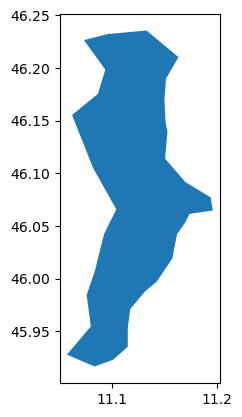

In [11]:
import geopandas as gpd
buffer_dist = 2000
agglom_extent_filepath = 'data/raw/agglom-extent/agglom-extent.shp'
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)
crs = agglom_extent_gdf.crs
ref_geom = agglom_extent_gdf.loc[0]['geometry'].buffer(buffer_dist)
agglom_extent_gdf.plot()

In [12]:
#just to be sure reproject agglom_extent_gdf from 4326 to 32632
agglom_extent_gdf = agglom_extent_gdf.to_crs('EPSG:32632')

/home/beber/mambaforge/envs/uhi/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

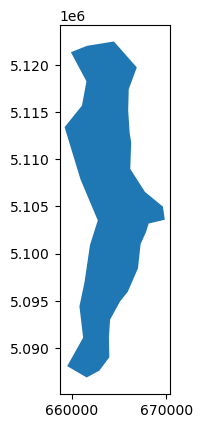

In [13]:
crs = agglom_extent_gdf.crs
ref_geom = agglom_extent_gdf.loc[0]['geometry'].buffer(buffer_dist)
agglom_extent_gdf.plot()

In [14]:
agglom_extent_gdf

,FID,geometry
0,0,"POLYGON ((659521.741 5088078.543, 661207.655 5..."


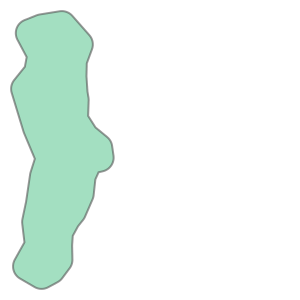

In [15]:
ref_geom

In [16]:
crs

'EPSG:32632'

In [17]:
# first time need to make a ds_ref
# for the first tile

ref_ds = None
if ref_ds is None:
    landsat_ds = geo_utils.clip_ds_to_extent(landsat_ds, geom=ref_geom,
                                                 crs=crs, roi=False,
                                                 subset_kws=None,
                                                 roi_kws=None)
    
else:
    landsat_ds = ref_ds.salem.transform(landsat_ds, interp='linear')


In [18]:
landsat_ds

<xarray.Dataset>
Dimensions:  (x: 487, y: 1319)
Coordinates:
  * x        (x) float64 6.573e+05 6.573e+05 6.573e+05 ... 6.718e+05 6.718e+05
  * y        (y) float64 5.124e+06 5.124e+06 5.124e+06 ... 5.085e+06 5.085e+06
Data variables:
    NDVI     (y, x) float32 0.82674646 0.7752773 0.71800596 ... nan nan
    NDWI     (y, x) float32 -0.7666657 -0.7277764 -0.67663103 ... nan nan
    LST      (y, x) float32 300.50348 300.96823 301.3617 ... 290.91714 nan nan
Attributes:
    pyproj_srs:  +proj=utm +zone=32 +datum=WGS84 +units=m +no_defs

In [19]:
dims = ('y', 'x')
coords = {
        'x': landsat_ds.salem.grid.x_coord,
        'y': landsat_ds.salem.grid.y_coord
    }

In [ ]:
# landsat_features_ds = xr.Dataset(
#         {
#             landsat_feature_key: xr.DataArray(
#                 landsat_features_dict[landsat_feature_key], dims=dims,
#                 coords=coords, attrs=proj_attrs)
#             for landsat_feature_key in landsat_features_dict
#         }, attrs=proj_attrs)

In [20]:
proj_attrs

{'pyproj_srs': '+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs'}

In [22]:
# # assemble the final dataset
#     dims = ('y', 'x')
#     coords = {
#         'x': landsat_ds.salem.grid.x_coord,
#         'y': landsat_ds.salem.grid.y_coord
#     }
#     landsat_features_ds = xr.Dataset(
#         {
#             landsat_feature_key: xr.DataArray(
#                 landsat_features_dict[landsat_feature_key], dims=dims,
#                 coords=coords, attrs=proj_attrs)
#             for landsat_feature_key in landsat_features_dict
#         }, attrs=proj_attrs)
    # add the date
landsat_features_ds = landsat_ds.copy()
landsat_features_ds = landsat_features_ds.assign_coords({
        'time':
        pd.to_datetime(pd.to_datetime('20220706'))
    })



In [23]:
landsat_features_ds

<xarray.Dataset>
Dimensions:  (x: 487, y: 1319)
Coordinates:
  * x        (x) float64 6.573e+05 6.573e+05 6.573e+05 ... 6.718e+05 6.718e+05
  * y        (y) float64 5.124e+06 5.124e+06 5.124e+06 ... 5.085e+06 5.085e+06
    time     datetime64[ns] 2022-07-06
Data variables:
    NDVI     (y, x) float32 0.82674646 0.7752773 0.71800596 ... nan nan
    NDWI     (y, x) float32 -0.7666657 -0.7277764 -0.67663103 ... nan nan
    LST      (y, x) float32 300.50348 300.96823 301.3617 ... 290.91714 nan nan
Attributes:
    pyproj_srs:  +proj=utm +zone=32 +datum=WGS84 +units=m +no_defs

In [24]:
datasets = []
datasets.append(landsat_features_ds)

In [43]:
datasets

NameError: name 'datasets' is not defined

# tile 1

In [1]:

datasets = []

In [2]:
import pandas as pd

In [63]:
# now let's do it for the other tiles
tile0 = 'uhi_LC08_193028_20220718.tif'
data = '20220718'

In [64]:
lst_gee_tiles = 'data/raw/landsat_gee_tiles/gee_uhi-20230118T151928Z-001/gee_uhi/'

In [65]:
# bad way
!gdal_translate -b 9 {lst_gee_tiles+tile0} ndvi.tif


Input file size is 1020, 1324
0...10...20...30...40...50...60...70...80...90...100 - done.


In [66]:
!gdal_translate -b 10 {lst_gee_tiles+tile0} ndwi.tif


Input file size is 1020, 1324
0...10...20...30...40...50...60...70...80...90...100 - done.


In [67]:
!gdal_translate -b 17 {lst_gee_tiles+tile0} lst.tif


Input file size is 1020, 1324
0...10...20...30...40...50...60...70...80...90...100 - done.


In [68]:
! mv *.tif {lst_gee_tiles}

In [69]:
# to be run only from second tile
landsat_ds_old = landsat_ds.copy()

In [70]:
# create xarray dataset
import xarray as xr
import salem
#
band_filepaths = [lst_gee_tiles+ 'ndvi.tif',lst_gee_tiles+ 'ndwi.tif',lst_gee_tiles + 'lst.tif']
bands = ['NDVI','NDWI','LST']
landsat_ds = xr.Dataset({
            band: salem.open_xr_dataset(band_filepath)['data']
            for band, band_filepath in zip(bands, band_filepaths)})

In [71]:
# needed to force the pyproj, since otherwise  >> https://salem.readthedocs.io/en/v0.2.3/faq.html#why-is-my-dataset-not-supported-dataset-grid-not-understood-error
#solution>> https://salem.readthedocs.io/en/latest/xarray_acc.html#custom-projection

landsat_ds.attrs['pyproj_srs'] = 'epsg:32632'

In [46]:
from swiss_uhi_utils import geo_utils

<AxesSubplot:>

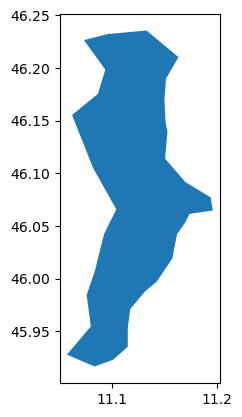

In [47]:
import geopandas as gpd
buffer_dist = 2000
agglom_extent_filepath = 'data/raw/agglom-extent/agglom-extent.shp'
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)
#crs = agglom_extent_gdf.crs
#ref_geom = agglom_extent_gdf.loc[0]['geometry'].buffer(buffer_dist)
agglom_extent_gdf.plot()

In [48]:
#just to be sure reproject agglom_extent_gdf from 4326 to 32632
agglom_extent_gdf = agglom_extent_gdf.to_crs('EPSG:32632')

/home/beber/mambaforge/envs/uhi/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

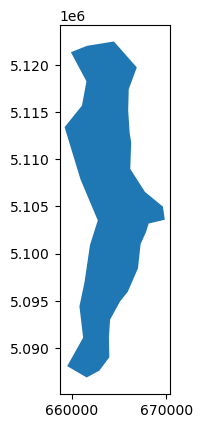

In [49]:
crs = agglom_extent_gdf.crs
ref_geom = agglom_extent_gdf.loc[0]['geometry'].buffer(buffer_dist)
agglom_extent_gdf.plot()

In [50]:
crs

'EPSG:32632'

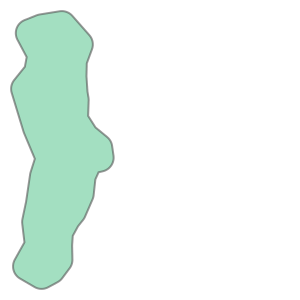

In [51]:
ref_geom

In [52]:
landsat_ds.attrs

{'pyproj_srs': 'epsg:32632'}

In [53]:
salem.version.version

'0.2.4'

In [72]:
from swiss_uhi_utils import geo_utils
# first time need to make a ds_ref
# for the first tile

ref_ds = landsat_ds_old #None #after first tile not None
if ref_ds is None:
    landsat_ds = geo_utils.clip_ds_to_extent(landsat_ds, geom=ref_geom,
                                                 crs=crs, roi=False,
                                                 subset_kws=None,
                                                 roi_kws=None)
    
else:
    landsat_ds = ref_ds.salem.transform(landsat_ds, interp='linear')


In [73]:
landsat_features_ds = landsat_ds.copy()
landsat_features_ds = landsat_features_ds.assign_coords({
        'time':
        pd.to_datetime(pd.to_datetime(data, format = '%Y%m%d'))
    })

In [74]:

datasets.append(landsat_features_ds)

In [75]:
datasets

[<xarray.Dataset>
 Dimensions:  (x: 487, y: 1319)
 Coordinates:
   * x        (x) float64 6.573e+05 6.573e+05 6.573e+05 ... 6.718e+05 6.718e+05
   * y        (y) float64 5.124e+06 5.124e+06 5.124e+06 ... 5.085e+06 5.085e+06
     time     datetime64[ns] 2022-06-25
 Data variables:
     NDVI     (y, x) float32 0.82674646 0.7752773 0.71800596 ... nan nan
     NDWI     (y, x) float32 -0.7666657 -0.7277764 -0.67663103 ... nan nan
     LST      (y, x) float32 300.50348 300.96823 301.3617 ... 290.91714 nan nan
 Attributes:
     pyproj_srs:  epsg:32632,
 <xarray.Dataset>
 Dimensions:  (x: 487, y: 1319)
 Coordinates:
   * x        (x) float64 6.573e+05 6.573e+05 6.573e+05 ... 6.718e+05 6.718e+05
   * y        (y) float64 5.124e+06 5.124e+06 5.124e+06 ... 5.085e+06 5.085e+06
     time     datetime64[ns] 2022-07-02
 Data variables:
     NDVI     (y, x) float32 0.8233043 0.8340537 ... 1.0009882 0.96210927
     NDWI     (y, x) float32 -0.76083535 -0.76821685 ... -0.866932 -0.8567729
     LST      (

In [95]:
agglom_landsat_ds

<xarray.Dataset>
Dimensions:  (time: 4, x: 487, y: 1319)
Coordinates:
  * y        (y) float64 5.124e+06 5.124e+06 5.124e+06 ... 5.085e+06 5.085e+06
  * x        (x) float64 6.573e+05 6.573e+05 6.573e+05 ... 6.718e+05 6.718e+05
  * time     (time) datetime64[ns] 2022-06-25 2022-07-02 2022-07-11 2022-07-18
Data variables:
    NDVI     (time, y, x) float32 0.82674646 0.7752773 0.71800596 ... nan nan
    NDWI     (time, y, x) float32 -0.7666657 -0.7277764 -0.67663103 ... nan nan
    LST      (time, y, x) float32 300.50348 300.96823 301.3617 ... nan nan nan
Attributes:
    pyproj_srs:  epsg:32632

In [87]:
abb =  agglom_landsat_ds.copy()
abb

<xarray.Dataset>
Dimensions:  (time: 4, x: 487, y: 1319)
Coordinates:
  * y        (y) float64 5.124e+06 5.124e+06 5.124e+06 ... 5.085e+06 5.085e+06
  * x        (x) float64 6.573e+05 6.573e+05 6.573e+05 ... 6.718e+05 6.718e+05
  * time     (time) datetime64[ns] 2022-06-25 2022-07-02 2022-07-11 2022-07-18
Data variables:
    NDVI     (time, y, x) float32 0.82674646 0.7752773 0.71800596 ... nan nan
    NDWI     (time, y, x) float32 -0.7666657 -0.7277764 -0.67663103 ... nan nan
    LST      (time, y, x) float32 300.50348 300.96823 301.3617 ... nan nan nan
Attributes:
    pyproj_srs:  epsg:32632

In [89]:
abb['LST'] = abb.LST - 273.15

In [90]:
abb


<xarray.Dataset>
Dimensions:  (time: 4, x: 487, y: 1319)
Coordinates:
  * y        (y) float64 5.124e+06 5.124e+06 5.124e+06 ... 5.085e+06 5.085e+06
  * x        (x) float64 6.573e+05 6.573e+05 6.573e+05 ... 6.718e+05 6.718e+05
  * time     (time) datetime64[ns] 2022-06-25 2022-07-02 2022-07-11 2022-07-18
Data variables:
    NDVI     (time, y, x) float32 0.82674646 0.7752773 0.71800596 ... nan nan
    NDWI     (time, y, x) float32 -0.7666657 -0.7277764 -0.67663103 ... nan nan
    LST      (time, y, x) float32 27.353485 27.818237 28.2117 ... nan nan nan
Attributes:
    pyproj_srs:  epsg:32632

In [97]:
# Convert Kelvin to celsius
agglom_landsat_ds['LST'] = agglom_landsat_ds.LST - 273.15

In [98]:
agglom_landsat_ds

<xarray.Dataset>
Dimensions:  (time: 4, x: 487, y: 1319)
Coordinates:
  * y        (y) float64 5.124e+06 5.124e+06 5.124e+06 ... 5.085e+06 5.085e+06
  * x        (x) float64 6.573e+05 6.573e+05 6.573e+05 ... 6.718e+05 6.718e+05
  * time     (time) datetime64[ns] 2022-06-25 2022-07-02 2022-07-11 2022-07-18
Data variables:
    NDVI     (time, y, x) float32 0.82674646 0.7752773 0.71800596 ... nan nan
    NDWI     (time, y, x) float32 -0.7666657 -0.7277764 -0.67663103 ... nan nan
    LST      (time, y, x) float32 27.353485 27.818237 28.2117 ... nan nan nan
Attributes:
    pyproj_srs:  epsg:32632

In [99]:
# save dataset to nc file
import xarray as xr
import os
from os import path
dst_filepath = lst_gee_tiles + 'landsat-features.nc'
#uncomment in order to reuse datasets
#agglom_landsat_ds = xr.concat(datasets, dim='time')
if path.exists(dst_filepath):
    os.remove(dst_filepath)
agglom_landsat_ds.to_netcdf(dst_filepath)
    #logger.info("dumped landsat features dataset to %s", dst_filepath)